02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [1]:
import os
import warnings
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [2]:
# データの読み込み
path_train_prepro = '../../../../data/processed/train_processed_0619.csv'
train = pd.read_csv(path_train_prepro)

# 分類用
train_cls = train.copy()
train_cls.target = train.target.apply(lambda x: 0 if x<-33 else 1)
target_cls = train_cls['target']
del train_cls['target']

# 回帰用
train_reg = train.query('target > -30').reset_index(drop=True)
target_reg = train_reg['target']
del train_reg['target']

# # 目的変数と説明変数の作成
target = train['target']
del train['target']

In [3]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = ['feature_1','feature_2', 'feature_3','hist_merchant_category_nu','hist_merchant_category_mode','hist_city_nu','hist_city_mode','hist_state_nu','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod','total_merchant_category_nu','total_merchant_category_mode','total_city_nu','total_city_mode','total_state_nu','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod']
#categorical_feats = ['feature_1','feature_2', 'feature_3','hist_merchant_category_nu','hist_merchant_category_mode','hist_city_nu','hist_city_mode','hist_state_nu','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod']

In [4]:
features

['first_active_month',
 'feature_1',
 'feature_2',
 'feature_3',
 'elapsed_time',
 'hist_frequency',
 'hist_amount_total',
 'hist_amount_mean',
 'hist_merchant_category_nu',
 'hist_merchant_category_mode',
 'hist_city_nu',
 'hist_city_mode',
 'hist_state_nu',
 'hist_state_mode',
 'hist_date_min',
 'hist_date_max',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_month_lag_mean',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_category_1_mod',
 'hist_category_2_mod',
 'hist_category_3_mod',
 'hist_ratio_No',
 'hist_ratio_Yes',
 'hist_count_No',
 'hist_count_Yes',
 'hist_duration',
 'total_frequency',
 'total_amount_total',
 'total_amount_mean',
 'total_merchant_category_nu',
 'total_merchant_category_mode',
 'total_city_nu',
 'total_city_mode',
 'total_state_nu',
 'total_state_mode',
 'total_date_min',
 'total_date_max',
 'total_installments_mean',
 'total_installments_max',
 'total_installments_min',
 'total_month_lag_mean',
 'total_month_lag_m

## 回帰

In [19]:
print(len(target_reg[target_reg>0]))

97609


In [20]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [21]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train_reg))
predictions = np.zeros(len(target_reg))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_reg.values, target_reg.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_reg.iloc[trn_idx][features],
                           label=target_reg.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train_reg.iloc[val_idx][features],
                           label=target_reg.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train_reg.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_11_reg/', exist_ok=True)
    with open(f'../src/models/lgb_11_reg/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target_reg)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.69149
[200]	valid_0's rmse: 1.67415
[300]	valid_0's rmse: 1.66528
[400]	valid_0's rmse: 1.65967
[500]	valid_0's rmse: 1.65635
[600]	valid_0's rmse: 1.65377
[700]	valid_0's rmse: 1.65148
[800]	valid_0's rmse: 1.64986
[900]	valid_0's rmse: 1.64803
[1000]	valid_0's rmse: 1.64654
[1100]	valid_0's rmse: 1.64512
[1200]	valid_0's rmse: 1.64366
[1300]	valid_0's rmse: 1.64243
[1400]	valid_0's rmse: 1.64151
[1500]	valid_0's rmse: 1.64044
[1600]	valid_0's rmse: 1.63946
[1700]	valid_0's rmse: 1.63868
[1800]	valid_0's rmse: 1.6378
[1900]	valid_0's rmse: 1.637
[2000]	valid_0's rmse: 1.63647
[2100]	valid_0's rmse: 1.63593
[2200]	valid_0's rmse: 1.63548
[2300]	valid_0's rmse: 1.63505
[2400]	valid_0's rmse: 1.63467
[2500]	valid_0's rmse: 1.63426
[2600]	valid_0's rmse: 1.63396
[2700]	valid_0's rmse: 1.63372
[2800]	valid_0's rmse: 1.63349
[2900]	valid_0's rmse: 1.63325
[3000]	valid_0's rmse: 1.63299
[3100]	vali

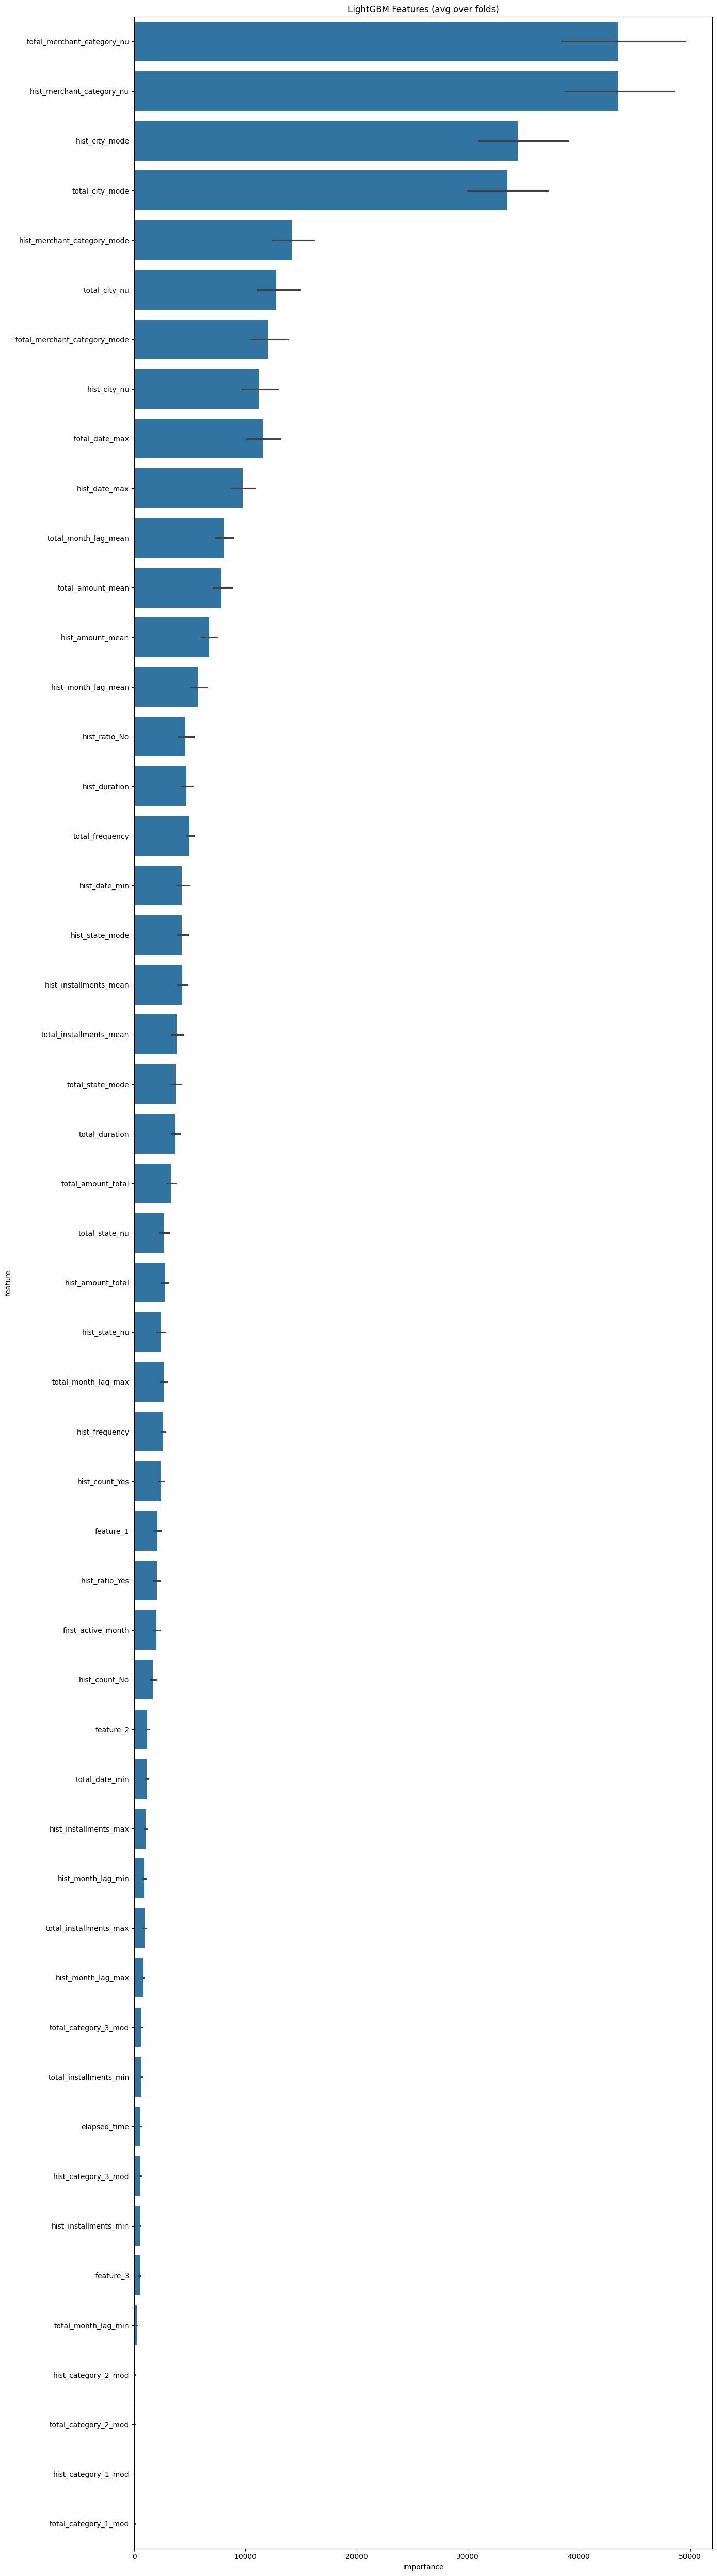

In [22]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

## 分類

In [8]:
# ハイパーパラメータを指定
param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 100000,
    'importance_type': 'gain',
    'num_leaves': 100,
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 10,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'random_seed': 26,
    'verbosity': -1
}

In [9]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train_cls))
predictions = np.zeros(len(target_cls))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_cls.values, target_cls.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_cls.iloc[trn_idx][features],
                           label=target_cls.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train_cls.iloc[val_idx][features],
                           label=target_cls.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    oof[val_idx] = clf.predict(train_cls.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_11_cls/', exist_ok=True)
    with open(f'../src/models/lgb_11_cls/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV AUC score: {:<8.5f}".format(roc_auc_score(target_cls, oof)))

fold n°0


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.88475
[200]	valid_0's auc: 0.882849
Early stopping, best iteration is:
[53]	valid_0's auc: 0.885751
fold n°1


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.889792
[200]	valid_0's auc: 0.889373
[300]	valid_0's auc: 0.888575
Early stopping, best iteration is:
[120]	valid_0's auc: 0.89057
fold n°2


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.869635
[200]	valid_0's auc: 0.870947
[300]	valid_0's auc: 0.871188
[400]	valid_0's auc: 0.870621
Early stopping, best iteration is:
[215]	valid_0's auc: 0.871453
fold n°3


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.865197
[200]	valid_0's auc: 0.866739
[300]	valid_0's auc: 0.865383
Early stopping, best iteration is:
[175]	valid_0's auc: 0.867555
fold n°4


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.894485
[200]	valid_0's auc: 0.894474
[300]	valid_0's auc: 0.892975
Early stopping, best iteration is:
[132]	valid_0's auc: 0.895485
CV AUC score: 0.87184 


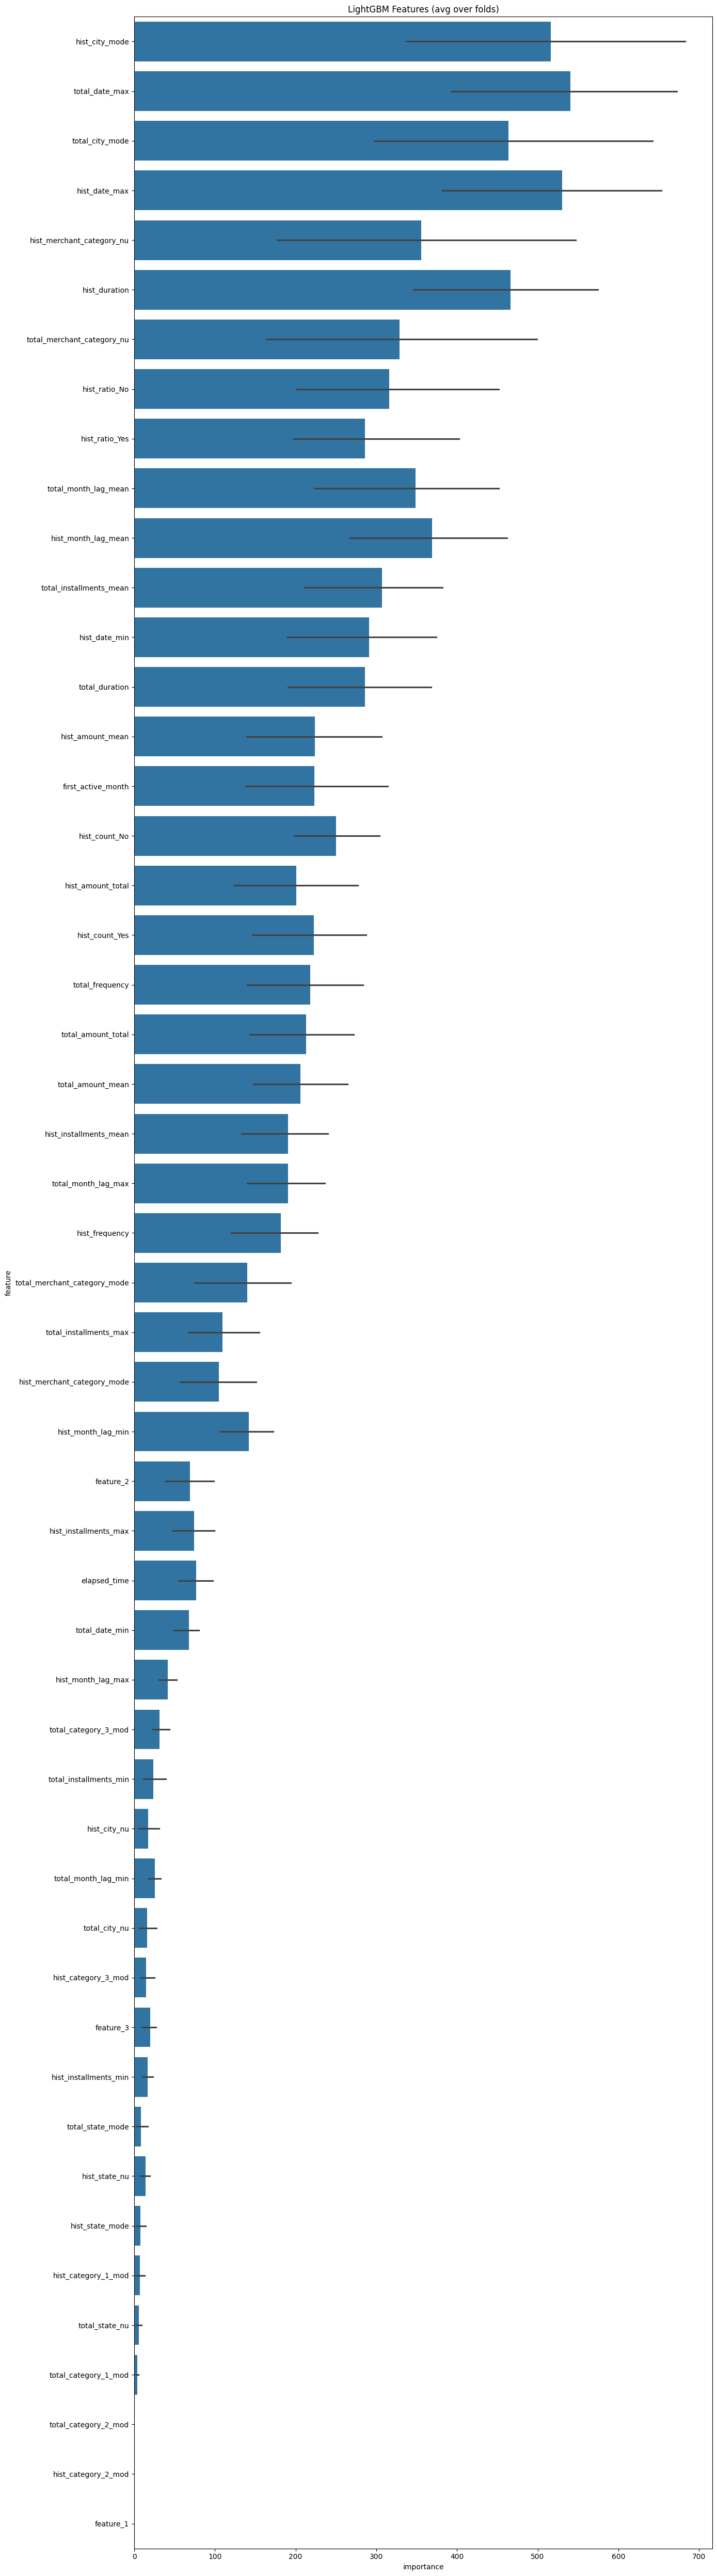

In [10]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')